# Bước 4: FP-Growth Modeling for Association Rules

Notebook này sử dụng ma trận `basket_bool` (được chuẩn bị ở Bước 02) để:

- Khai thác tập mục phổ biến (frequent itemsets) bằng thuật toán FP-Growth
- Sinh luật kết hợp (association rules) với các chỉ số: `support`, `confidence`, `lift`
- Lọc luật theo các ngưỡng do người dùng cấu hình
- Trực quan hoá một số nhóm luật tiêu biểu phục vụ storytelling & phân tích kinh doanh
- So sánh sơ bộ thời gian chạy và số lượng luật thu được so với Apriori (sẽ chi tiết hơn ở Bước 5)

Notebook được thiết kế theo kiểu parameterized để dễ dàng tích hợp với papermill.


In [1]:
# PARAMETERS (for papermill)

# Đường dẫn tới basket_bool được tạo từ Notebook 02
BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"

# Đường dẫn lưu file luật kết hợp sau khi lọc (FP-Growth)
RULES_OUTPUT_PATH = "data/processed/rules_fpgrowth_filtered.csv"

# Tham số cho bước khai thác tập mục phổ biến (frequent itemsets)
MIN_SUPPORT = 0.01  # ngưỡng support tối thiểu
MAX_LEN = 3         # độ dài tối đa của itemset (số sản phẩm trong 1 tập)

# Tham số cho bước sinh luật
METRIC = "lift"     # chỉ số dùng để generate rules: 'support' / 'confidence' / 'lift'
MIN_THRESHOLD = 1.0 # ngưỡng tối thiểu cho METRIC

# Tham số lọc luật sau khi generate
FILTER_MIN_SUPPORT = 0.01
FILTER_MIN_CONF = 0.3
FILTER_MIN_LIFT = 1.2
FILTER_MAX_ANTECEDENTS = 2
FILTER_MAX_CONSEQUENTS = 1

# Số lượng luật top để vẽ biểu đồ
TOP_N_RULES = 20

# Bật/tắt các biểu đồ matplotlib
PLOT_TOP_LIFT = True
PLOT_TOP_CONF = True
PLOT_SCATTER = True
PLOT_NETWORK = True

# Bật/tắt biểu đồ HTML tương tác (Plotly)
PLOT_PLOTLY_SCATTER = True


In [2]:
# Parameters
BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"
RULES_OUTPUT_PATH = "data/processed/rules_fpgrowth_filtered.csv"
MIN_SUPPORT = 0.01
MAX_LEN = 3
METRIC = "lift"
MIN_THRESHOLD = 1.0
FILTER_MIN_SUPPORT = 0.01
FILTER_MIN_CONF = 0.3
FILTER_MIN_LIFT = 1.2
FILTER_MAX_ANTECEDENTS = 2
FILTER_MAX_CONSEQUENTS = 1
TOP_N_RULES = 20
PLOT_TOP_LIFT = True
PLOT_TOP_CONF = True
PLOT_SCATTER = True
PLOT_NETWORK = True
PLOT_PLOTLY_SCATTER = True


## Set up

In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Biểu đồ tương tác HTML
import plotly.express as px

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import FPGrowthMiner, DataVisualizer  


## Thiết lập style vẽ biểu đồ


In [4]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

visualizer = DataVisualizer()


## Tải basket_bool


In [5]:
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("=== Thông tin basket_bool ===")
print(f"- Số hoá đơn (rows): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (columns): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (có mua): {basket_bool.values.mean():.4f}")

basket_bool.head()


=== Thông tin basket_bool ===
- Số hoá đơn (rows): 18,021
- Số sản phẩm (columns): 4,007
- Tỷ lệ ô = 1 (có mua): 0.0066


4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
0                           False                           False   
1                           False                           False   
2                           False                           False   
3                           False                           False   
4                           False                           False   

    DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK   NINE DRAWER OFFICE TIDY  \
0               False                         False                     False   
1               False                         False                     False   
2               False                         False                     False   
3               False                         False                     False   
4               False                         False                     False   

    OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE  \
0                        False                     False   
1                        False                     False   
2                        False                     False   
3                        False                     False   
4                        False                     False   

    SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET  \
0                             False                    False   
1                             False                    False   
2                             False                    False   
3                             False                    False   
4                             False                    False   

    TOADSTOOL BEDSIDE LIGHT   ...  ZINC STAR T-LIGHT HOLDER   \
0                      False  ...                      False   
1                      False  ...                      False   
2                      False  ...                      False   
3                      False  ...                      False   
4                      False  ...                      False   

   ZINC SWEETHEART SOAP DISH  ZINC SWEETHEART WIRE LETTER RACK  \
0                      False                             False   
1                      False                             False   
2                      False                             False   
3                      False                             False   
4                      False                             False   

   ZINC T-LIGHT HOLDER STAR LARGE  ZINC T-LIGHT HOLDER STARS LARGE  \
0                           False                            False   
1                           False                            False   
2                           False                            False   
3                           False                            False   
4                           False                            False   

   ZINC T-LIGHT HOLDER STARS SMALL  ZINC TOP  2 DOOR WOODEN SHELF   \
0                            False                           False   
1                            False                           False   
2                            False                           False   
3                            False                           False   
4                            False                           False   

   ZINC WILLIE WINKIE  CANDLE STICK  ZINC WIRE KITCHEN ORGANISER  \
0                             False                        False   
1                             False                        False   
2                             False                        False   
3                             False                        False   
4                             False                        False   

   ZINC WIRE SWEETHEART LETTER TRAY  
0                             False  
1                             False  
2                             False  
3                             False  
4                             False  

[5 rows x 4007 columns]

## Khai thác tập phổ biến bằng thuật toán FP-Growth


In [6]:
# Khởi tạo FP-Growth miner
fp_miner = FPGrowthMiner(basket_bool=basket_bool)

start_time = time.time()
frequent_itemsets_fp = fp_miner.mine_frequent_itemsets(
    min_support=MIN_SUPPORT,
    max_len=MAX_LEN,
    use_colnames=True,
)
elapsed_time = time.time() - start_time

print("=== Kết quả khai thác tập mục phổ biến (FP-Growth) ===")
print(f"- Thời gian chạy: {elapsed_time:.2f} giây")
print(f"- Số tập mục phổ biến thu được: {len(frequent_itemsets_fp):,}")

frequent_itemsets_fp.head(10)


=== Kết quả khai thác tập mục phổ biến (FP-Growth) ===
- Thời gian chạy: 72.70 giây
- Số tập mục phổ biến thu được: 2,120


support                              itemsets
0    0.119971  (WHITE HANGING HEART T-LIGHT HOLDER)
84   0.107375             (JUMBO BAG RED RETROSPOT)
300  0.093502            (REGENCY CAKESTAND 3 TIER)
601  0.088397                       (PARTY BUNTING)
29   0.077243             (LUNCH BAG RED RETROSPOT)
7    0.076078       (ASSORTED COLOUR BIRD ORNAMENT)
637  0.068864   (SET OF 3 CAKE TINS PANTRY DESIGN )
71   0.067643     (NATURAL SLATE HEART CHALKBOARD )
161  0.067477             (LUNCH BAG  BLACK SKULL.)
72   0.064591               (HEART OF WICKER SMALL)

/home/namdh/.conda/envs/shopping_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/namdh/.conda/envs/shopping_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/namdh/.conda/envs/shopping_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py:916: UserWarning: Glyph 7897 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.tight_layout()
/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py

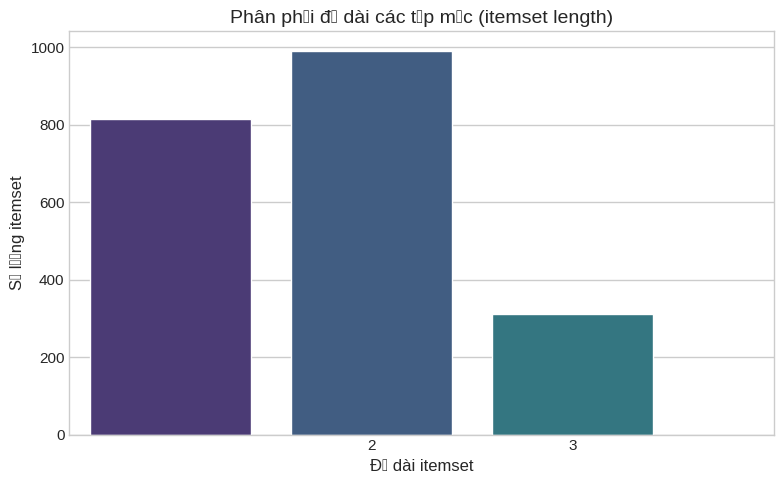

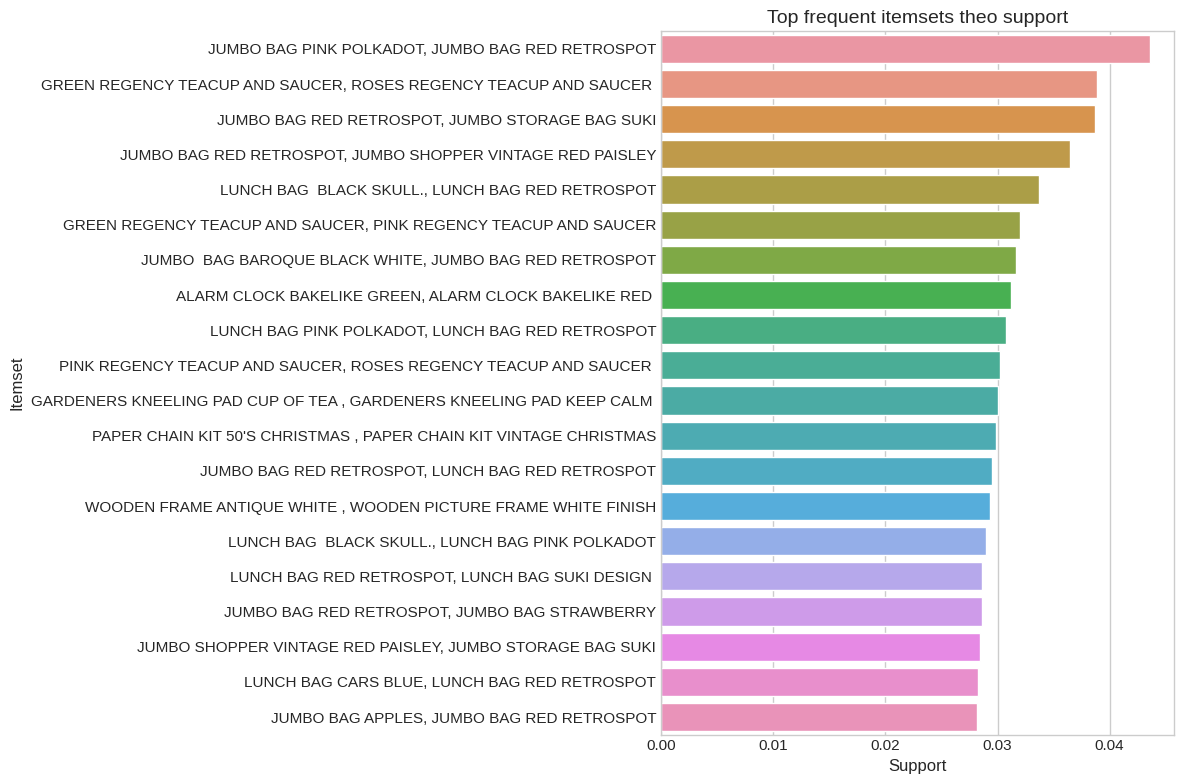

In [7]:
if frequent_itemsets_fp is not None and not frequent_itemsets_fp.empty:
    # Phân phối độ dài các tập mục (1-itemset, 2-itemset, 3-itemset, ...)
    visualizer.plot_itemset_length_distribution(
        frequent_itemsets=frequent_itemsets_fp
    )

    # Top các tập mục phổ biến nhất theo support (ưu tiên itemset có từ 2 sản phẩm trở lên)
    visualizer.plot_top_frequent_itemsets(
        frequent_itemsets=frequent_itemsets_fp,
        top_n=20,
        min_len=2,
    )
else:
    print("Không có frequent itemsets để trực quan hoá.")


## Sinh luật kết hợp từ tập mục phổ biến (FP-Growth)


In [8]:
rules_fp = fp_miner.generate_rules(
    metric=METRIC,
    min_threshold=MIN_THRESHOLD,
)

# Thêm cột dạng chuỗi dễ đọc
rules_fp = fp_miner.add_readable_rule_str()

print("=== Một vài luật kết hợp đầu tiên (FP-Growth, chưa lọc) ===")
cols_preview = [
    "antecedents_str",
    "consequents_str",
    "support",
    "confidence",
    "lift",
]
rules_fp[cols_preview].head(10)


=== Một vài luật kết hợp đầu tiên (FP-Growth, chưa lọc) ===


antecedents_str  \
2602  HERB MARKER PARSLEY, HERB MARKER ROSEMARY   
2603                          HERB MARKER THYME   
2982        HERB MARKER MINT, HERB MARKER THYME   
2987                       HERB MARKER ROSEMARY   
3220        HERB MARKER MINT, HERB MARKER THYME   
3225                        HERB MARKER PARSLEY   
2600     HERB MARKER PARSLEY, HERB MARKER THYME   
2605                       HERB MARKER ROSEMARY   
2890       HERB MARKER BASIL, HERB MARKER THYME   
2895                       HERB MARKER ROSEMARY   

                                consequents_str   support  confidence  \
2602                          HERB MARKER THYME  0.010932    0.951691   
2603  HERB MARKER PARSLEY, HERB MARKER ROSEMARY  0.010932    0.856522   
2982                       HERB MARKER ROSEMARY  0.010599    0.955000   
2987        HERB MARKER MINT, HERB MARKER THYME  0.010599    0.826840   
3220                        HERB MARKER PARSLEY  0.010432    0.940000   
3225        HERB MARKER MINT, HERB MARKER THYME  0.010432    0.824561   
2600                       HERB MARKER ROSEMARY  0.010932    0.951691   
2605     HERB MARKER PARSLEY, HERB MARKER THYME  0.010932    0.852814   
2890                       HERB MARKER ROSEMARY  0.010710    0.950739   
2895       HERB MARKER BASIL, HERB MARKER THYME  0.010710    0.835498   

           lift  
2602  74.567045  
2603  74.567045  
2982  74.502403  
2987  74.502403  
3220  74.297105  
3225  74.297105  
2600  74.244244  
2605  74.244244  
2890  74.169983  
2895  74.169983

## Lọc các luật FP-Growth theo ngưỡng support / confidence / lift


In [9]:
rules_filtered_fp = fp_miner.filter_rules(
    min_support=FILTER_MIN_SUPPORT,
    min_confidence=FILTER_MIN_CONF,
    min_lift=FILTER_MIN_LIFT,
    max_len_antecedents=FILTER_MAX_ANTECEDENTS,
    max_len_consequents=FILTER_MAX_CONSEQUENTS,
)

print("=== Thống kê sau khi lọc luật (FP-Growth) ===")
print(f"- Tổng số luật ban đầu: {rules_fp.shape[0]:,}")
print(f"- Số luật sau khi lọc: {rules_filtered_fp.shape[0]:,}")

rules_filtered_fp[cols_preview].head(10)


=== Thống kê sau khi lọc luật (FP-Growth) ===
- Tổng số luật ban đầu: 3,856
- Số luật sau khi lọc: 1,794


antecedents_str       consequents_str   support  \
0  HERB MARKER PARSLEY, HERB MARKER ROSEMARY     HERB MARKER THYME  0.010932   
1        HERB MARKER MINT, HERB MARKER THYME  HERB MARKER ROSEMARY  0.010599   
2        HERB MARKER MINT, HERB MARKER THYME   HERB MARKER PARSLEY  0.010432   
3     HERB MARKER PARSLEY, HERB MARKER THYME  HERB MARKER ROSEMARY  0.010932   
4       HERB MARKER BASIL, HERB MARKER THYME  HERB MARKER ROSEMARY  0.010710   
5    HERB MARKER BASIL, HERB MARKER ROSEMARY     HERB MARKER THYME  0.010710   
6     HERB MARKER MINT, HERB MARKER ROSEMARY     HERB MARKER THYME  0.010599   
7     HERB MARKER MINT, HERB MARKER ROSEMARY   HERB MARKER PARSLEY  0.010488   
8       HERB MARKER BASIL, HERB MARKER THYME   HERB MARKER PARSLEY  0.010377   
9                        HERB MARKER CHIVES    HERB MARKER PARSLEY  0.010377   

   confidence       lift  
0    0.951691  74.567045  
1    0.955000  74.502403  
2    0.940000  74.297105  
3    0.951691  74.244244  
4    0.950739  74.169983  
5    0.936893  73.407619  
6    0.931707  73.001294  
7    0.921951  72.870539  
8    0.921182  72.809761  
9    0.921182  72.809761

/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py:950: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.tight_layout()


/home/namdh/.conda/envs/shopping_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


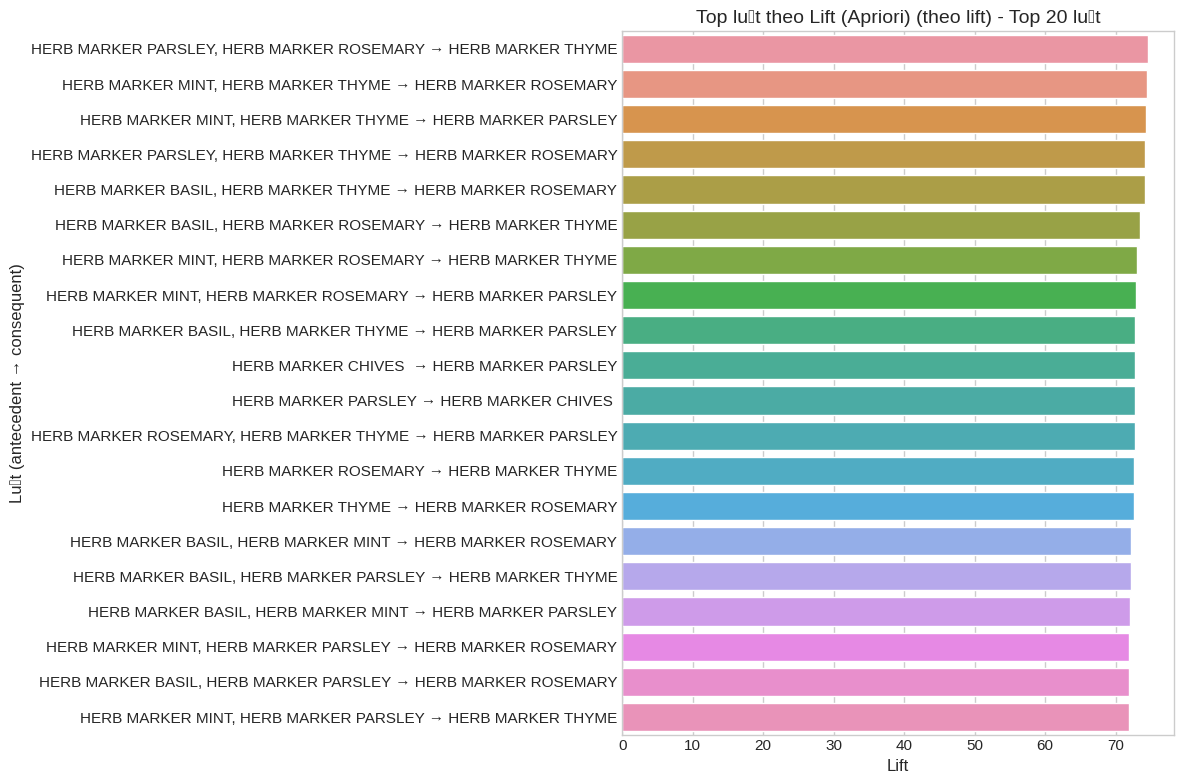

In [10]:
# Cell 16: Top theo lift
if PLOT_TOP_LIFT and not rules_filtered_fp.empty:
    visualizer.plot_top_rules_lift(
        rules_df=rules_filtered_fp,
        top_n=TOP_N_RULES,
    )
else:
    if rules_filtered_fp.empty:
        print("Không có luật nào sau khi lọc để vẽ top lift.")
    else:
        print("PLOT_TOP_LIFT = False, bỏ qua biểu đồ top lift.")


/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py:950: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.tight_layout()
/home/namdh/.conda/envs/shopping_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


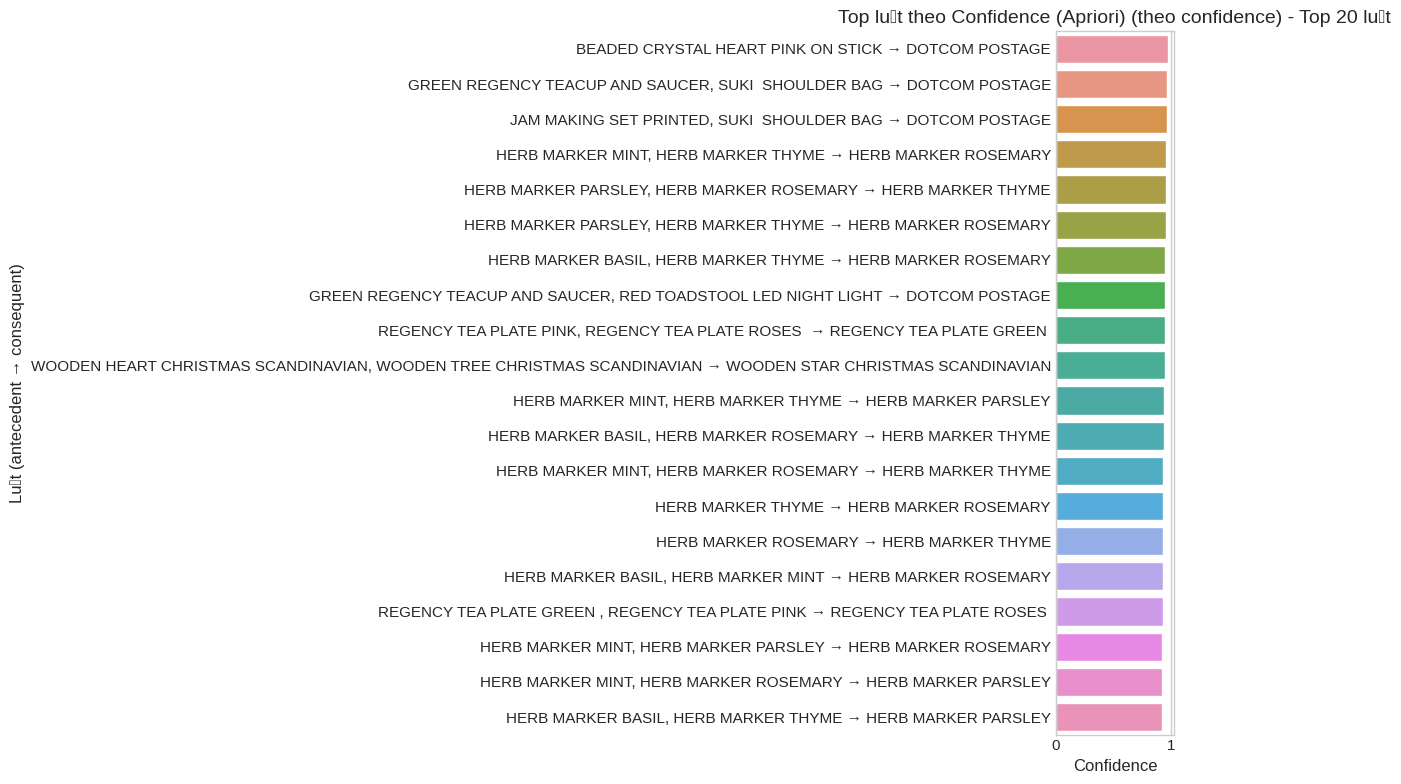

In [11]:
# Cell 17: Top theo confidence
if PLOT_TOP_CONF and not rules_filtered_fp.empty:
    visualizer.plot_top_rules_confidence(
        rules_df=rules_filtered_fp,
        top_n=TOP_N_RULES,
    )
else:
    if rules_filtered_fp.empty:
        print("Không có luật nào sau khi lọc để vẽ top confidence.")
    else:
        print("PLOT_TOP_CONF = False, bỏ qua biểu đồ top confidence.")


/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py:1033: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  plt.tight_layout()
/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py:1033: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.tight_layout()


/home/namdh/.conda/envs/shopping_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


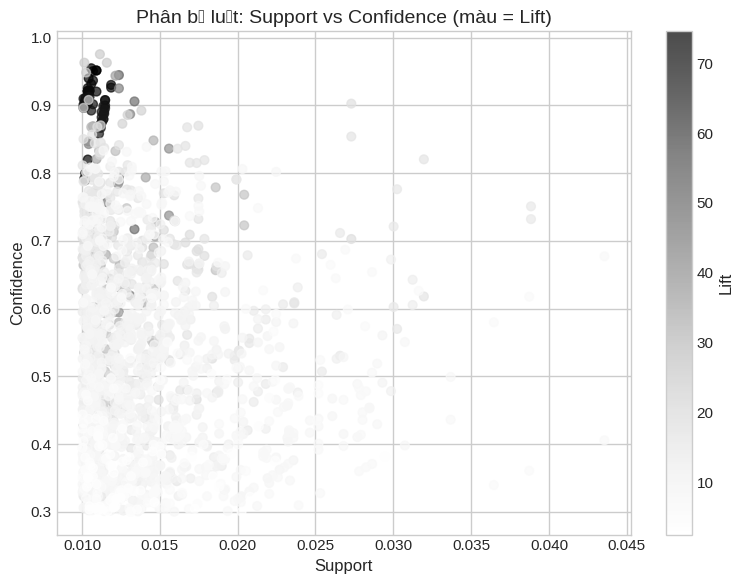

In [12]:
# Cell 18: Scatter support–confidence
if PLOT_SCATTER and not rules_filtered_fp.empty:
    visualizer.plot_rules_support_confidence_scatter(
        rules_df=rules_filtered_fp,
    )
else:
    if rules_filtered_fp.empty:
        print("Không có luật nào sau khi lọc để vẽ scatter.")
    else:
        print("PLOT_SCATTER = False, bỏ qua biểu đồ scatter.")


In [13]:
# Cell 19: Scatter Plotly
if PLOT_PLOTLY_SCATTER and not rules_filtered_fp.empty:
    visualizer.plot_rules_support_confidence_scatter_interactive(
        rules_df=rules_filtered_fp,
    )
else:
    if rules_filtered_fp.empty:
        print("Không có luật nào sau khi lọc để vẽ scatter Plotly.")
    else:
        print("PLOT_PLOTLY_SCATTER = False, bỏ qua biểu đồ Plotly.")


/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py:1229: UserWarning:

Glyph 7841 (\N{LATIN SMALL LETTER A WITH DOT BELOW}) missing from current font.

/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py:1229: UserWarning:

Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from current font.

/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py:1229: UserWarning:

Glyph 7899 (\N{LATIN SMALL LETTER O WITH HORN AND ACUTE}) missing from current font.

/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py:1229: UserWarning:

Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.

/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py:1229: UserWarning:

Glyph 7871 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND ACUTE}) missing from current font.

/hdd3/namdh/datamining/shop_cluster_/src/cluster_library.py:1229: UserWarning:

Glyph 7907 (\N{LATIN SMALL LETTER O WITH HORN AND DOT BELOW}) missing from current font.



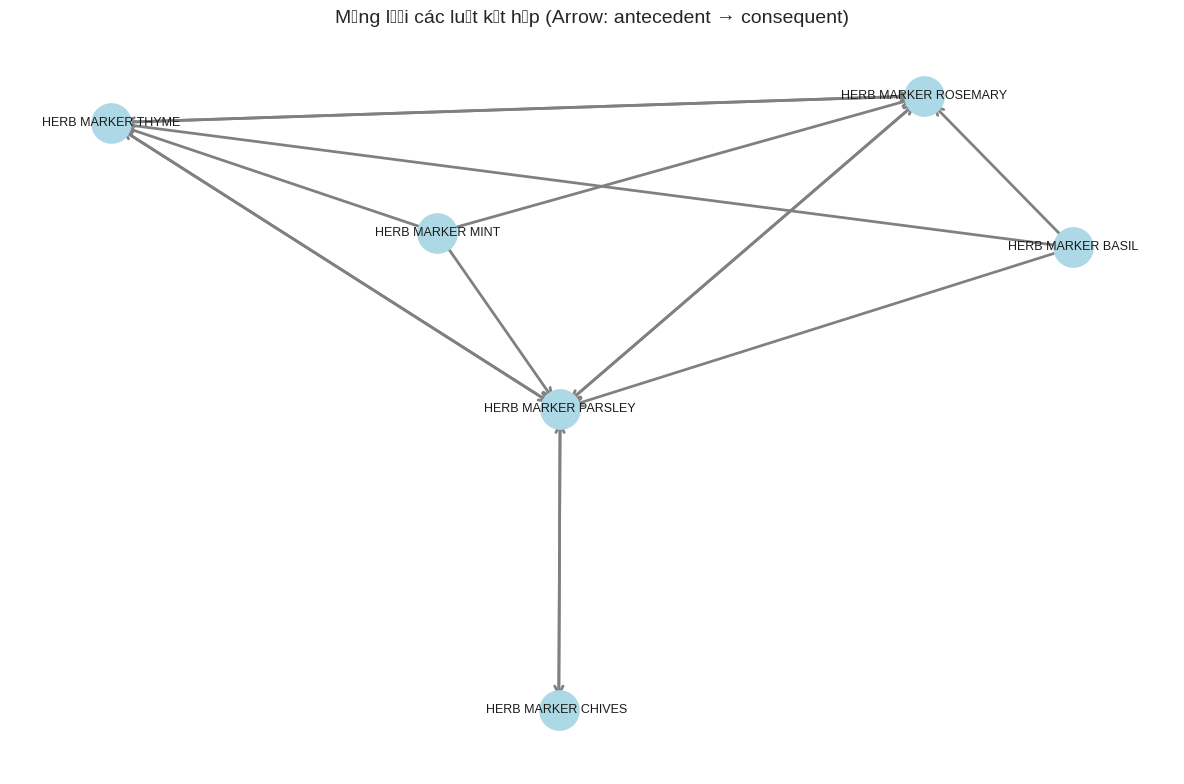

In [14]:
# Cell 20: Network graph
if PLOT_NETWORK and not rules_filtered_fp.empty:
    visualizer.plot_rules_network(
        rules_df=rules_filtered_fp,
        max_rules=min(TOP_N_RULES, 30),
    )
else:
    if rules_filtered_fp.empty:
        print("Không có luật nào sau khi lọc để vẽ network graph.")
    else:
        print("PLOT_NETWORK = False, bỏ qua network graph.")


In [15]:
fp_miner.save_rules(
    output_path=RULES_OUTPUT_PATH,
    rules_df=rules_filtered_fp,
)

print("Đã lưu luật FP-Growth đã lọc:")
print(f"- File: {RULES_OUTPUT_PATH}")
print(f"- Số luật: {rules_filtered_fp.shape[0]:,}")


Đã lưu luật vào: data/processed/rules_fpgrowth_filtered.csv
Đã lưu luật FP-Growth đã lọc:
- File: data/processed/rules_fpgrowth_filtered.csv
- Số luật: 1,794
